# Weather Map Detection and Analysis
This project uses several image processing techniques to vectorize a loop of weather map readars with the end goal of creating a total accumulation map in millimeters. It uses well known rainfall rates from NOAA based on dBZ values shown in doppler radar images. These dBZ - rain rate correlations from the NOAA are discrete and very disparate. To make this a continuous relationship and create an accurate mapping, the project uses exponential regression and interpolation. A relationship is created with these dBZ - rain rates and the RGB values from the radar key legend, which forms the crux of converting each loop of the radar into rain rate amounts. Image blurring is used to soften some noise in the final result.

Requirements: 
- Must name each image with a similar naming convention: e.g., \[State\]\_doppler\_\[i\]
- Include an image without any doppler radar (only the county lines) with naming convention \[State\]\_doppler\_e
- Change the naming convention and file path in the below code (directory and filename_struct)

## Imports and Installs

In [1]:
"""
All needed imports and installs for the project
"""

# pip install opencv-python
# pip install pyglet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import cv2 as cv
import os
import math
import seaborn as sns
import imageio.v2 as io
import glob
import pyglet
from PIL import Image
from PIL import ImageEnhance
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

## Displaying each radar image as GIF

In [3]:
"""
This code reads in all radar images from the specified directory 
and with the given file name structure. Each image is cut  down to 
take out the edges of the screenshot. 
"""

directory = os.getcwd()
filename_struct = "Lou_doppler"

# Initializing the count of images in our directory
count = 0
images = []

for filename in sorted(os.listdir(directory)):
    if filename.startswith(filename_struct):
        f = os.path.join(directory, filename)
        images.append(io.imread(f))

# Cutting out the top and bottom of each image
i = 0
for pic in images:
    pic = pic[math.ceil(len(pic) * 0.20) : math.ceil(len(pic) * 0.80)]
    images[i] = pic
    i += 1

io.mimsave(directory + "/" + "radar.gif", images, fps=1.7)

ag_file = directory + "/" + "radar.gif"
animation = pyglet.image.load_animation(ag_file)
sprite = pyglet.sprite.Sprite(animation)
sprite.update(scale=0.5)

# Create a window and set it to the image size with
# specified window background color
win = pyglet.window.Window(width=sprite.width, height=sprite.height)
green = 0, 1, 0, 1
pyglet.gl.glClearColor(*green)


# Definitions to control displaying and closing the GIF
@win.event
def on_draw():
    win.clear()
    sprite.draw()


def close(event):
    win.close()


pyglet.clock.schedule_once(close, 8.0)

pyglet.app.run()

2024-02-20 07:02:49.747 Python[23138:3198043] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/vr/_3gy4clj6932_zwdwb7jml_m0000gn/T/org.python.python.savedState


## Creating dBZ and rainfall rate mapping 

The noaa_dBZ_rates dataframe below correlates rainfall rates in mm to dBZ values \(taken from NOAA website\). We need to get granular values for rainfall rates per dBZ value. We use exponential regression and interpolation to fit a curve to the known values. 
\
\
The model for exponential data is $y = A*e^{\lambda x}$. Taking the log on both sides of $y$, we get $\log(y) = \log(A) + \lambda x$ These relationships are used in the creation of our model.

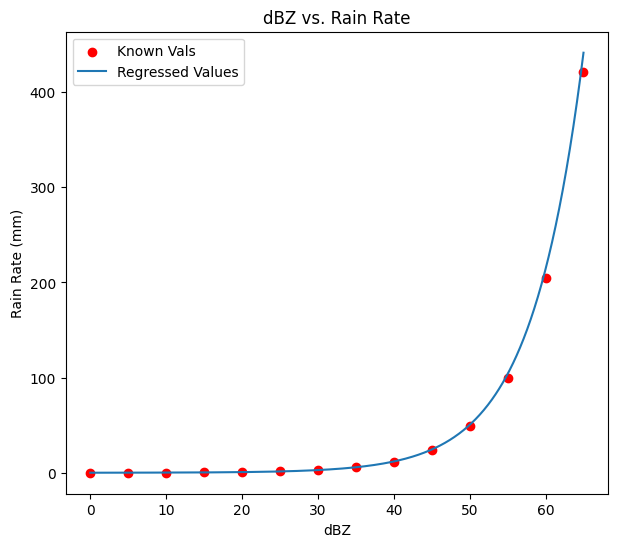

In [11]:
"""
dBZ values go from about 0 to 65 on this key from NOAA, so 
lets use regression and interpolation to get more granular rainfall 
rates per dBZ value in mm
"""

noaa_dBZ_rates = pd.DataFrame(
    data=[
        [0, 0.07, 0.15, 0.3, 0.6, 1.3, 2.7, 5.6, 11.53, 23.7, 48.6, 100, 205, 421],
        [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65],
    ],
    index=["rain_rate", "dBZ"],
)
noaa_dBZ_rates = noaa_dBZ_rates.transpose()

x = noaa_dBZ_rates["dBZ"]
y = noaa_dBZ_rates["rain_rate"]

"""
To gain a more accurate and smooth curve, we interpolate the 
non-zero x and y values. First, fit our model with the log of y,
calculate y with the inverse of the log (exponential), create array
of nulls and insert known values in every other position, interpolate
null values, and repeat.At the end add back in 0 rain rate values. 
"""

while len(y) < 1000:
    dbz_model = np.polyfit(x[1:], np.log(y[1:]), 1)
    y = np.exp(dbz_model[1]) * np.exp(dbz_model[0] * x)

    nan_vals_y = np.full(len(y) * 2, np.nan)
    nan_vals_y[::2] = y
    nan_vals_x = np.full(len(x) * 2, np.nan)
    nan_vals_x[::2] = x

    new_y = pd.Series(nan_vals_y)
    new_x = pd.Series(nan_vals_x)

    y = new_y.interpolate()
    x = new_x.interpolate()
y[:5] = 0

fig = plt.figure(figsize=(7, 6))
plt.title("dBZ vs. Rain Rate")
plt.xlabel("dBZ")
plt.ylabel("Rain Rate (mm)")
plt.scatter(
    noaa_dBZ_rates["dBZ"], noaa_dBZ_rates["rain_rate"], c="red", label="Known Vals"
)
plt.plot(x, y, label="Regressed Values")
plt.legend()
plt.show()

## Reading and Formatting the Radar Key

The radar key or radar legend is the key to connecting the RGB values in the image to the dBZ - rain rates. We will read the radar key image. Then, we can take one horizontal slice of the image for the unique BGR values to dBZ - rain rate assignment.

In [5]:
# Reading the radar key and indexing to only show the dBZ key scale

radar_key = cv.imread(f"{directory}/radar_scale_key.jpg", cv.IMREAD_COLOR)

radar_key = radar_key[:25, 0:890, :]

# Creating an array that represents only unique color values

radar_key_unique = radar_key[:, 0]
for i in range(radar_key.shape[1] - 1):
    array_1 = radar_key[:, i]
    array_2 = radar_key[:, i + 1]
    if np.array_equal(array_1, array_2):
        continue
    else:
        radar_key_unique = np.concatenate((radar_key_unique, array_2), axis=0)

# Reshaping the radar_key image to be groups of 25 for display purposes.
# We have ~400 unique color values

dim_2 = int(radar_key_unique.shape[0] / 25)
radar_key_unique = np.reshape(radar_key_unique, (dim_2, 25, 3))

# Resizing the x and y dBZ and rain rate arrays to match
# that of the radar key unique array. This is so we can relate
# the two exactly.
x = np.unique(x)
y = np.unique(y)

index_array = np.ceil(np.linspace(0, len(y), radar_key_unique.shape[0])).astype(int)

x_last = x[index_array[-1] - 1]
y_last = y[index_array[-1] - 1]

x = x[index_array[:-1]]
y = y[index_array[:-1]]

x = np.append(x, x_last)
y = np.append(y, y_last)

# Color array with all possible BGR values. The color array is used to fill
# a dictionary stacked_vals with any BGR values not already present in the
# radar key.

byte = range(256)
colors = np.array(np.meshgrid(byte, byte, byte), dtype=np.uint8).T.reshape(-1, 3)

radar_key_rgb = []
radar_key_convert = cv.cvtColor(radar_key_unique, cv.COLOR_BGR2RGB)
for i in range(len(radar_key_convert)):
    radar_slice = tuple(radar_key_convert[i, 0, :])
    radar_key_rgb.append(radar_slice)

stacked_vals = dict(zip(radar_key_rgb, zip(x, y)))

for col in colors:
    if tuple(col) in stacked_vals:
        continue
    else:
        stacked_vals[tuple(col)] = None

# Creating a dataframe of all color/dBZ/rain rate vals, sorting it,
# then filling any null values vertically

df_interpole = pd.DataFrame(stacked_vals.items(), columns=["RGB", "dBZ"])

df_interpole = df_interpole.sort_values("RGB")

df_interpole = df_interpole.ffill()
my_dict = dict(zip(df_interpole["RGB"], df_interpole["dBZ"]))

The dBZ value is: 59.140625
The rain rate in mm/hr is: 193.3471249809377
The rain rate in in/hr is: 7.6120915346825875


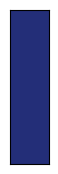

In [6]:
"""
To demonstrate that the key matches with the rain rate 
and dBZ values, we choose a random slice,display the color, 
and print the dBZ and rain rate.
"""

slice = np.random.randint(0, len(radar_key_unique))

fig = plt.figure(figsize=(8, 2))
plt.imshow(np.tile(radar_key_unique[slice], (100, 1)).reshape(100, 25, 3))
plt.xticks([])
plt.yticks([])

print("The dBZ value is:", x[slice])
print("The rain rate in mm/hr is:", y[slice])
print("The rain rate in in/hr is:", y[slice] / 25.4)

## Converting Images to Totals

In [7]:
# Re-read our images into a dictionary
# Counting how many image files we have in our directory
count = 0
for filename in os.listdir(directory):
    if filename.startswith(filename_struct):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            count += 1

# For each image read, subtract the empty image with only county lines.
# This prevents the county lines from being converted to rainfall rates.
images = {}
for i in range(1, count):
    images[filename_struct + str(i)] = cv.imread(
        f"{directory}/{filename_struct}{i}.PNG", cv.IMREAD_COLOR
    ) - cv.imread(f"{directory}/{filename_struct}_e.PNG", cv.IMREAD_COLOR)

# Convert each image from BGR to RGB and index to only include
# the radar image from the screenshot and not iPhone headers/footers.
for i in range(1, count):
    images[filename_struct + str(i)] = cv.cvtColor(
        images[filename_struct + str(i)], cv.COLOR_BGR2RGB
    )
    images[filename_struct + str(i)] = images[filename_struct + str(i)][
        math.ceil(len(images[filename_struct + str(i)]) * 0.15) : math.ceil(
            len(images[filename_struct + str(i)]) * 0.80
        )
    ]

# Width and height used for resizing after adding up totals
width = images[filename_struct + str(i)].shape[1]
height = images[filename_struct + str(i)].shape[0]

# Creating mapped images, using the color/rain rate dictionary to
# relate RGB vals to mm per hour vals
images_mapped = {}
image_hold = {}
for i in range(1, count):
    image_hold[filename_struct + str(i)] = images[filename_struct + str(i)].reshape(
        width * height, 3
    )
    image_hold[filename_struct + str(i)] = [
        tuple(k) for k in image_hold[filename_struct + str(i)]
    ]
    images_mapped[filename_struct + str(i)] = [
        my_dict.get(j) for j in image_hold[filename_struct + str(i)]
    ]

# Adding up each mapped image for a totals array
images_mapped_total = np.array(
    [[0.0, 0.0]] * len(images_mapped[filename_struct + str(1)])
)

for i in range(1, count):
    images_mapped[filename_struct + str(i)] = [
        list(k) for k in images_mapped[filename_struct + str(i)]
    ]
    images_mapped_total += np.array(images_mapped[filename_struct + str(i)])

# Introducing a blur to take out extraneous noise when visualizing
images_mapped_total = cv.GaussianBlur(images_mapped_total, (3, 3), 0)

# Each radar loop is ~5 or ~6 minutes, so we multiply the totals by 0.08
# since these values are per hour values.
images_mapped_total = (images_mapped_total * 0.08).astype("int")

# Reading in our empty radar image with only county lines and resizing similar
# to above. This is used in visualization.
images_empty = cv.imread(f"{directory}/{filename_struct}_e.PNG", cv.IMREAD_COLOR)
images_empty = cv.cvtColor(images_empty, cv.COLOR_BGR2RGB)
images_empty = images_empty[
    math.ceil(len(images_empty) * 0.15) : math.ceil(len(images_empty) * 0.80)
]

## Visualizing Result

We use a normalization process with the desired color map to create our image. The normalization is based on min/max, and the maximum is reduced as the absolute max rainfall usually only occurs at a singular place in our map (it can be thought of as an outlier). It is displayed along with a key using the same normalization and color map. 

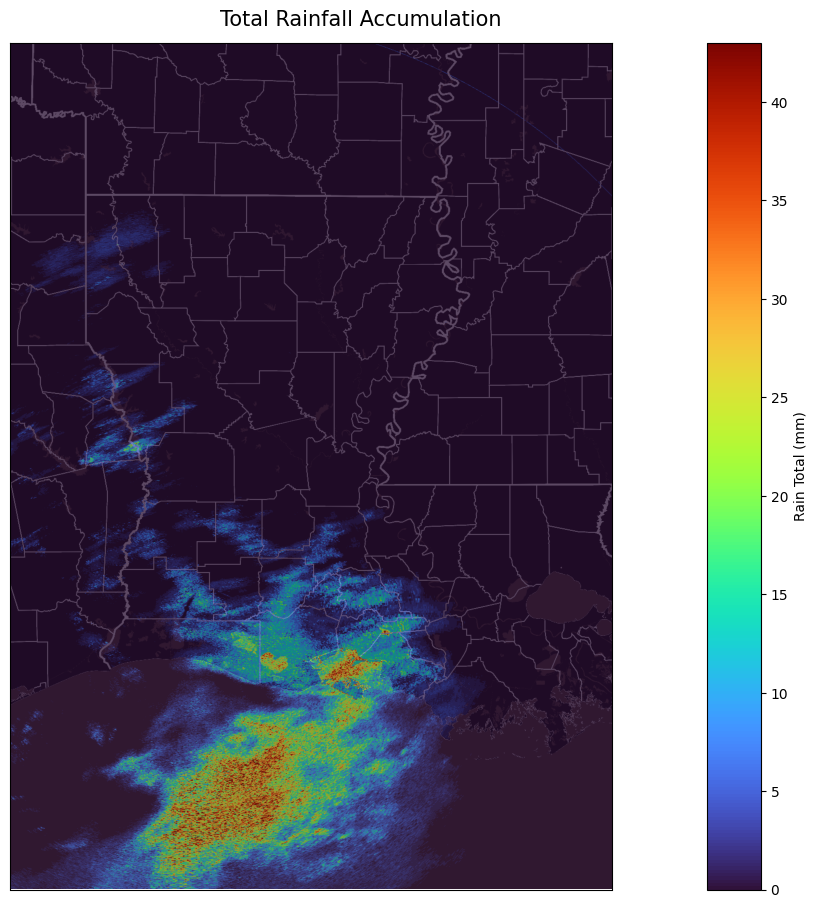

In [10]:
"""
min and max (max at 60 percent of true max) used for normalization. 
Then each rain rate value in images_mapped_total is converted to our 
turbo BGR values.
"""

var_min = np.min(images_mapped_total[:, 1])
var_max = np.floor(np.max(images_mapped_total[:, 1]) * 0.60)
var_list = np.linspace(var_min, var_max, 1000)
var_norm = Normalize(vmin=var_min, vmax=var_max, clip=False)
mapper = cm.ScalarMappable(norm=var_norm, cmap=cm.turbo)
RGB = np.array(
    [
        list((b, g, r))
        for r, g, b, a in mapper.to_rgba(images_mapped_total[:, 1], bytes=False)
    ]
)
RGB = RGB.reshape(height, width, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 11), width_ratios=[12, 1])
fig.suptitle("Total Rainfall Accumulation", fontsize=15, y=0.91)
ax1.imshow(cv.cvtColor(RGB.astype("float32"), cv.COLOR_RGB2BGR))
ax1.imshow(cv.cvtColor(images_empty.astype("uint8"), cv.COLOR_RGB2BGR), alpha=0.35)
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(
    cm.ScalarMappable(norm=var_norm, cmap=cm.turbo),
    cax=ax2,
    orientation="vertical",
    label="Rain Total (mm)",
)

plt.show()